# Урок 8. Домашнее задание.

1. Можно ли отобрать наиболее значимые признаки с помощью PCA? Ответ объясните.

**Это сделать невозможно, так как при применении PCA образуются новые признаки, с целью уменьшения количества признаков с некоторой потерей данных.**

2. (\*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html). Применить к данным на уроке и сравнить ответы.

In [191]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [192]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [193]:
# Масштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по признаку
means = X_.mean(axis=0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]
        
# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for j in range(cols):
    for i in range(rows):
        X_[i, j] /= std[j]

In [194]:
# Находим собственные векторы матрицы XTX
V = np.linalg.svd(X_)[2].T
V

array([[ 0.52106591, -0.37741762,  0.71956635,  0.26128628],
       [-0.26934744, -0.92329566, -0.24438178, -0.12350962],
       [ 0.5804131 , -0.02449161, -0.14212637, -0.80144925],
       [ 0.56485654, -0.06694199, -0.63427274,  0.52359713]])

In [195]:
D = np.linalg.svd(X_)[1] ** 2 # собственные значения матрицы XTX

In [196]:
# Доля дисперсии, описываемая каждой из компонент:
print(sorted([D[i] / sum(D) * 100 for i in range(len(D))], reverse=True))

[72.96244541329989, 22.850761786701746, 3.6689218892828785, 0.5178709107154802]


Выбираем две компоненты c долей дисперсии 72.96 и 22.85.

In [197]:
V = V[:, :2] # оставляем только 2 признака
V

array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

In [198]:
# Формируем новую матрицу объкеты-признаки:
Z = X_.dot(V)
Z.shape

(150, 2)

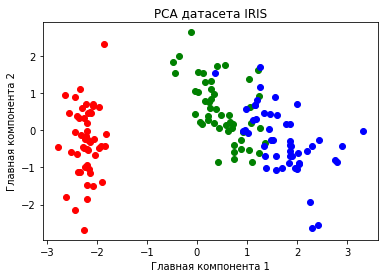

In [199]:
plt.figure()
y = iris.target
for c, i in zip('rgb', [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

3. (\*) Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

Возьмем алгоритм случайного леса для создания модели классификации на датасете IRIS

In [200]:
from sklearn import datasets, model_selection
import random

In [201]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [202]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [203]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction     

In [204]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [205]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [206]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [207]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf=1):

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [208]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_samples_leaf=1, max_depth=None, depth=0):

    quality, t, index = find_best_split(data, labels, min_samples_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    if max_depth and depth >= max_depth:
        return Leaf(data, labels)
    
    depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_samples_leaf, max_depth, depth)
    false_branch = build_tree(false_data, false_labels, min_samples_leaf, max_depth, depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [209]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [210]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [257]:
def random_forest(data, labels, n_trees, max_depth=None, min_samples_leaf=1, random_state=42):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, min_samples_leaf, max_depth))
        
    return forest

In [258]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [259]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [260]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [261]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.2,
                                                                    random_state = 1)

In [262]:
n_trees = 5

In [272]:
print(f'\033[31m \n Количество деревьев = {n_trees}')
my_forest = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest, train_data)
test_answers = tree_vote(my_forest, test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')


 
 Количество деревьев = 5
Точность случайного леса из 5 деревьев на обучающей выборке: 99.167
Точность случайного леса из 5 деревьев на тестовой выборке: 96.667


Обучение модели после применения метода главных компонент(PCA):

In [273]:
# Масштабируем выборку
train_data = train_data.astype(float)

rows, cols = train_data.shape

# центрирование - вычитание из каждого значения среднего по признаку
means = train_data.mean(axis=0)
for i in range(rows):
    for j in range(cols):
        train_data[i, j] -= means[j]
        
# деление каждого значения на стандартное отклонение
std = np.std(train_data, axis=0)
for j in range(cols):
    for i in range(rows):
        train_data[i, j] /= std[j]

In [274]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = train_data.T.dot(train_data)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
348.9783384751762
109.58899387320982
19.29461208160512
2.138055570009393


In [275]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.70382051566163, 22.83104039025202, 4.019710850334396, 0.44542824375195644]
Кумулятивная доля дисперсии по компонентам 
[ 72.70382052  95.53486091  99.55457176 100.        ]


In [276]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52828393 -0.33212851]
 [-0.25412962 -0.93919659]
 [ 0.58193019 -0.02900891]
 [ 0.56364126 -0.0822125 ]]


In [277]:
# Сформируем новую матрицу "объекты-признаки"
Z_train = train_data.dot(W)
Z_train.shape

(120, 2)

In [278]:
# Масштабируем тестовую выборку
test_data = test_data.astype(float)

rows, cols = test_data.shape

# центрирование - вычитание из каждого значения среднего по признаку
for i in range(rows):
    for j in range(cols):
        test_data[i, j] -= means[j]
        
# деление каждого значения на стандартное отклонение
for j in range(cols):
    for i in range(rows):
        test_data[i, j] /= std[j]

In [279]:
Z_test = test_data.dot(W)
Z_test.shape

(30, 2)

In [283]:
print(f'\033[31m \n Количество деревьев = {n_trees}')
my_forest = random_forest(Z_train, train_labels, n_trees)
train_answers = tree_vote(my_forest, Z_train)
test_answers = tree_vote(my_forest, Z_test)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

 
 Количество деревьев = 5
Точность случайного леса из 5 деревьев на обучающей выборке: 98.333
Точность случайного леса из 5 деревьев на тестовой выборке: 90.000


**При применении метода главных компонент ухудшилась точность работы модели на тестовой выборке, но уменьшились затраты на обучение модели.**